In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import datajoint as dj
from funconnect import connectomics as cncs, ta3, nda
from funconnect.connectomics import *
from funconnect import nda
import numpy as np
import pandas as pd
import pycircstat as circ
cncs.schema.spawn_missing_classes()

Connecting zhiwei@10.28.0.34:3306


# Orientation tuning

Set some parameters for the analysis

In [8]:
is_tuned = 'von_r2>0.05 and von_pvalue<0.05'
dori_resolution = np.pi / 2 / 4
rad2deg = 180/np.pi
bin_edges = np.linspace(0, np.pi,9)
be = list(['{:.0f}'.format(ee) for ee in [np.round(e * rad2deg) for e in bin_edges]])
bin_labels = list(zip(be[:-1], be[1:]))
bin_centers = np.round((bin_edges[1:] + bin_edges[:-1])/2 * rad2deg, decimals=2) 

In [9]:
bin_labels

[('0', '22'),
 ('22', '45'),
 ('45', '68'),
 ('68', '90'),
 ('90', '112'),
 ('112', '135'),
 ('135', '158'),
 ('158', '180')]

Massage the relations

In [10]:
tuned_rel = nda.VonMises() & is_tuned
best_r2 = dj.U('segment_id').aggr(tuned_rel, best_r2='max(von_r2)')
pref_rel = (tuned_rel * best_r2) & 'von_r2 >= best_r2'

p_cond = dict(p='n_seg_shared > 0')
# p_cond = dict(p='n_seg_shared = 10')
attrs = ['segment_a', 'segment_b', 'connection', 'n_seg_shared']
shi = (dj.U(*attrs) & SharedInput.proj('n_seg_shared', connection='shared_input_type', segment_a = 'segment_id')) + \
      (dj.U(*attrs) & SharedInput.proj('n_seg_shared', connection='shared_input_type', segment_a='segment_b', segment_b='segment_id')) #+ \
#       (dj.U(*attrs) & SharedContactPair.proj('segment_a', 'segment_b', n_seg_shared='n_axon_shared', connection='"contact"')) + \
#       (dj.U(*attrs) & SharedContactPair.proj(segment_b='segment_a', segment_a='segment_b', n_seg_shared='n_axon_shared', connection='"contact"')) 
rel2 = shi  * pref_rel.proj(ori_1='von_pref',dummy='scan_idx', segment_a='segment_id') * pref_rel.proj(segment_b='segment_id', ori_2='von_pref')

In [54]:
shi

segment_a segment id unique within each Segmentation,segment_b segment id unique within each Segmentation,connection,n_seg_shared number of shared segments
694582,421208,all,16
694582,421208,non-perisomatic,16
694582,421208,perisomatic,0
845222,421208,all,0
845222,694582,all,0
845222,421208,non-perisomatic,0
845222,694582,non-perisomatic,0


In [22]:
SharedInput()

segmentation segmentation id,segment_id segment id unique within each Segmentation,shared_input_type,segment_b segment id unique within each Segmentation,n_seg_shared number of shared segments
1,694582,all,421208,16
1,694582,non-perisomatic,421208,16
1,694582,perisomatic,421208,0
1,845222,all,421208,0
1,845222,all,694582,0
1,845222,non-perisomatic,421208,0
1,845222,non-perisomatic,694582,0


Fetch the dataframe and bin the orientations

In [60]:
df = pd.DataFrame(rel2.fetch())

df['dori'] = np.abs(circ.cdiff(2 * df['ori_1'], 2 * df['ori_2'])/2)
df['bdori'] = bin_centers[(np.digitize(np.abs(circ.cdiff(2 * df['ori_1'], 2 * df['ori_2'])/2), bin_edges))] #bug: should be bin_centers[... -1]

df['ori_1'] = (df['ori_1'] % np.pi) * rad2deg
df['ori_2'] = (df['ori_2'] % np.pi) * rad2deg

df['bori_1'] = bin_centers[(np.digitize(df['ori_1'] % np.pi, bin_edges))-1] #bug: should be (df['ori_1'] / rad2deg) % np.pi
df['bori_2'] = bin_centers[(np.digitize(df['ori_2'] % np.pi, bin_edges))-1]


In [73]:
nda.VonMises()

OperationalError: (2006, "MySQL server has gone away (BrokenPipeError(32, 'Broken pipe'))")

InterfaceError: (0, '')

In [62]:
bin_centers

array([ 11.25,  33.75,  56.25,  78.75, 101.25, 123.75, 146.25, 168.75])

In [64]:
bin_edges

array([0.        , 0.39269908, 0.78539816, 1.17809725, 1.57079633,
       1.96349541, 2.35619449, 2.74889357, 3.14159265])

In [63]:
df['ori_1'][0]

173.09456061358762

In [66]:
np.digitize(173 % 180, bin_edges)-1

8

In [61]:
df

,segment_a,segment_b,connection,n_seg_shared,segmentation,dummy,scan_idx,ori_1,ori_2,dori,bdori,bori_1,bori_2
0,2589588,942272,non-perisomatic,0,1,2,3,173.094561,111.476808,1.075433,78.75,11.25,78.75
1,2589588,55282126,perisomatic,0,1,2,2,173.094561,49.857489,0.990700,78.75,11.25,146.25
2,2589588,38469670,perisomatic,0,1,2,2,173.094561,135.836109,0.650283,56.25,11.25,33.75
3,2589588,72259575,perisomatic,0,1,2,3,173.094561,38.078546,0.785119,56.25,11.25,11.25
4,2589588,3841528,non-perisomatic,1,1,2,3,173.094561,4.135254,0.192696,33.75,11.25,56.25
5,2589588,91299685,all,3,1,2,2,173.094561,14.537257,0.374246,33.75,11.25,123.75
6,2589588,54125630,all,0,1,2,3,173.094561,45.547128,0.915470,78.75,11.25,78.75
7,2589588,65857274,all,1,1,2,4,173.094561,67.491984,1.298480,101.25,11.25,78.75
8,2589588,87953373,non-perisomatic,1,1,2,2,173.094561,166.649931,0.112480,33.75,11.25,11.25
9,2589588,59033263,non-perisomatic,0,1,2,3,173.094561,8.647079,0.271443,33.75,11.25,146.25


In [58]:
x = np.array([1.2, 10.0, 12.4, 15.5, 20.])
bins = np.array([0, 5, 10, 15, 20])
np.digitize(x,bins,right=False)

array([1, 3, 3, 4, 5])

In [59]:
bins[5]

IndexError: index 5 is out of bounds for axis 0 with size 5

In [50]:
circ.cdiff(2*270*np.pi/180, 2*50*np.pi/180)/2 *rad2deg

39.99999999999999

In [53]:
((2 * (270-50) + 180) % 360 - 180) /2

40.0

# Plot cumulative distributions

In [27]:
stuff = ['connection', 'bdori', 'n_seg_shared']

n = df.groupby(stuff)['dummy'].count().reset_index()
s = n.groupby(stuff[:-1]).transform('sum')
cs = n.groupby(stuff[:-1]).transform('cumsum')
n['P'] = 1 - cs['dummy']/s['dummy']
n['csum'] = cs['dummy']
n['sum'] = s['dummy']
n['prob'] = n['dummy']/s['dummy']
# n

## P(more than k shared segments| $\Delta \vartheta$)

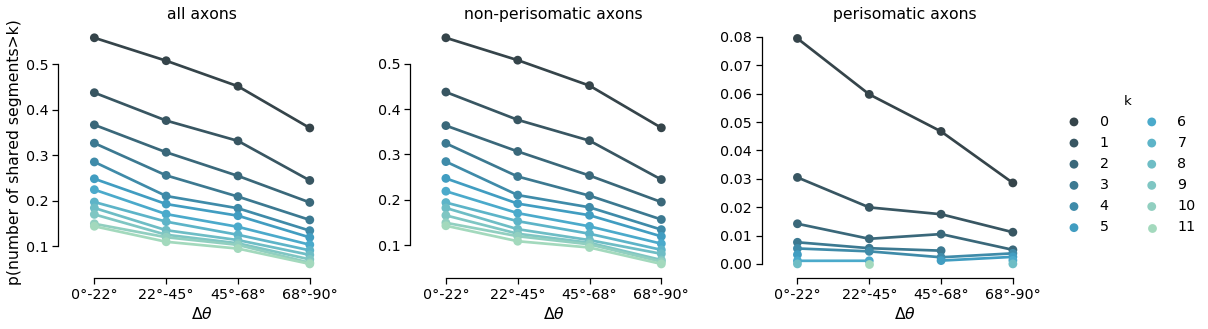

In [28]:
n['k'] = n['n_seg_shared']
sns.set_context('notebook', font_scale=1.3)
g = sns.catplot('bdori', 'P', data=n, kind='point', col='connection', hue='k', hue_order=np.arange(12), 
                palette=sns.color_palette("GnBu_d", n_colors=12), legend=False, legend_out=True, sharey=False)
g.set_titles('{col_name} axons')
g.set_axis_labels(y_var='p(number of shared segments>k)', x_var=r'$\Delta \theta$')
for ax in g.axes.ravel():
    ax.set_xticklabels(['{}°-{}°'.format(*a) for a in bin_labels], rotation=0)
# g.axes[0,-1].legend(title='k', ncol=3)
g.add_legend(title='k', ncol=2)

sns.despine(trim=True)
g.fig.subplots_adjust(bottom=.2)
g.fig.savefig('figures/shared_input_cumprob.png', dpi=200)
g.fig.savefig('figures/shared_input_cumprob.pdf')

# $\langle$ shared segments $\rangle$ as function of $\Delta \theta$

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


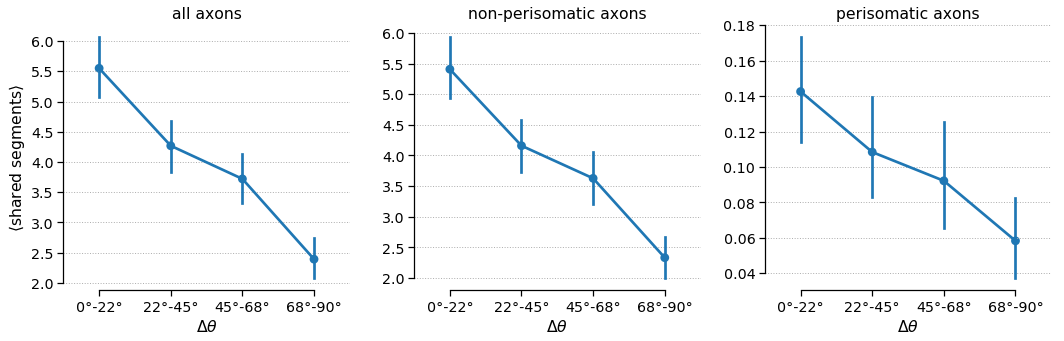

In [29]:
g = sns.catplot('bdori', 'n_seg_shared', data=df, kind='point', col='connection',  legend_out=True, sharey=False)
g.set_axis_labels(x_var=r'$\Delta \theta$', y_var=r'$\langle$shared segments$\rangle$')
# g.ax.set_yticks(np.arange(2,7))
# g.ax.yaxis.grid(True, linestyle=':')
for ax in g.axes.ravel():
    ax.yaxis.grid(True, linestyle=':')
    ax.set_xticklabels(['{}°-{}°'.format(*a) for a in bin_labels], rotation=0)
sns.despine(trim=True)
g.set_titles('{col_name} axons')
# g.ax.set_title('non-perisomatic axons')
g.fig.savefig('figures/average_shared_input.png', dpi=200)
g.fig.savefig('figures/average_shared_input.pdf')

# Combined plot

Get input density per postsynaptic neuron

In [119]:
segs = ta3.Synapse * pref_rel.proj(ori='von_pref', postsyn='segment_id') & (ta3.Neurite & dict(neurite_type='axon')).proj(presyn='segment_id')
df_segments = pd.DataFrame(segs.fetch())
df_segments['ori'] = (df_segments['ori'] % np.pi) * rad2deg
df_segments['bori'] = bin_centers[(np.digitize(df_segments['ori'] % np.pi, bin_edges))-1]
df_m = df_segments.groupby(['postsyn','ori','bori'])['presyn'].count().reset_index()

Get tuned neurons

In [120]:
df_tuned = pd.DataFrame(pref_rel.proj(ori='von_pref').fetch())
df_tuned['ori'] = (df_tuned['ori'] % np.pi) * rad2deg

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


NameError: name 'df_m' is not defined

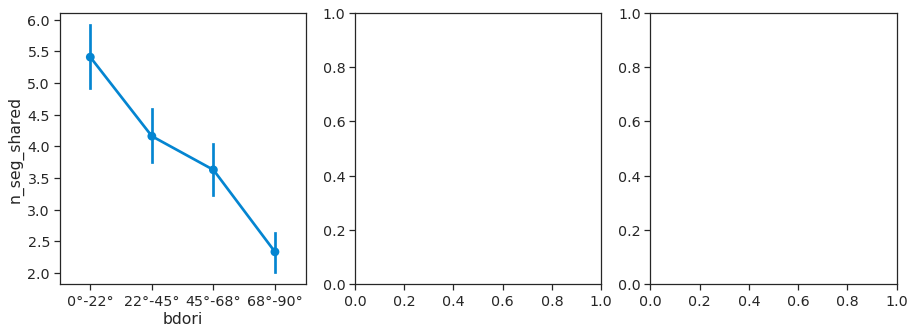

In [74]:
with sns.axes_style('ticks'):
    fig, ax = plt.subplots(1,3, figsize=(15,5))
blue = sns.xkcd_rgb['cerulean']
sns.pointplot('bdori', 'n_seg_shared', data=df[df.connection == 'non-perisomatic'], kind='point', ax=ax[0], color=blue)
ax[0].set_xticklabels(['{}°-{}°'.format(*a) for a in bin_labels], rotation=0)

# sns.distplot(df_segments.ori, ax=ax[1], kde=False, norm_hist=False,
#             hist_kws=dict(color=blue))
sns.barplot('bori', 'presyn', ax=ax[1], data=df_m, orient='vertical', color=blue)

sns.distplot(df_tuned.ori, ax=ax[2], kde=True, rug=True, 
             kde_kws=dict(bw=3, shade=True, color=blue), 
             rug_kws=dict(color='slategray'),
             hist=False)


ax[0].set_ylabel(r'$\langle$shared axons$\rangle$')
ax[0].set_xlabel(r'$\Delta \vartheta$')

xt = np.linspace(0, 180, 5)
for a in ax[1:]:
    a.set_xlabel(r'$\vartheta$')
ax[1].set_xticklabels(['{}°-{}°'.format(*a) for a in bin_labels], rotation=60)

ax[2].set_xticks(xt)
ax[2].set_xticklabels(['{}°'.format(t) for t in xt])
ax[1].set_ylabel('presynaptic axons per\npostsynaptic segment')
ax[2].set_ylabel('tuned segments density')

sns.despine(trim=True)
fig.tight_layout()
fig.savefig('figures/tuning_statistics.png', dpi=200)
fig.savefig('figures/tuning_statistics.pdf')

# Heatmap of preferred orientation and number of shared segments

In [71]:
df[df.connection == 'non-perisomatic'].groupby(['bori_1', 'bori_2'])['n_seg_shared'].mean().reset_index()

,bori_1,bori_2,n_seg_shared
0,11.25,11.25,1.222222
1,11.25,33.75,2.046154
2,11.25,56.25,3.362500
3,11.25,78.75,2.192308
4,11.25,101.25,1.600000
5,11.25,123.75,2.318182
6,11.25,146.25,1.240000
7,11.25,168.75,1.223077
8,33.75,11.25,2.046154
9,33.75,33.75,3.717949


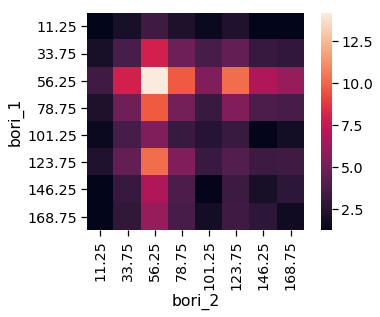

In [72]:
df2 = df[df.connection == 'non-perisomatic'].groupby(['bori_1', 'bori_2'])['n_seg_shared'].mean().reset_index()
df2 = df2.pivot('bori_1', 'bori_2', 'n_seg_shared')
g = sns.heatmap(df2, square=True)

bori_2,11.25,33.75,56.25,78.75,101.25,123.75,146.25,168.75
bori_1,,,,,,,,
11.25,1.222222,2.046154,3.362500,2.192308,1.600000,2.318182,1.240000,1.223077
33.75,2.046154,3.717949,8.000000,4.905325,3.641026,4.531469,3.138462,2.928994
56.25,3.362500,8.000000,14.214286,9.721154,5.416667,10.238636,6.850000,6.105769
78.75,2.192308,4.905325,9.721154,5.102564,3.192308,5.440559,3.815385,3.686391
101.25,1.600000,3.641026,5.416667,3.192308,2.533333,3.196970,1.316667,1.833333
123.75,2.318182,4.531469,10.238636,5.440559,3.196970,4.054545,3.300000,3.377622
146.25,1.240000,3.138462,6.850000,3.815385,1.316667,3.300000,2.044444,2.746154
168.75,1.223077,2.928994,6.105769,3.686391,1.833333,3.377622,2.746154,1.769231


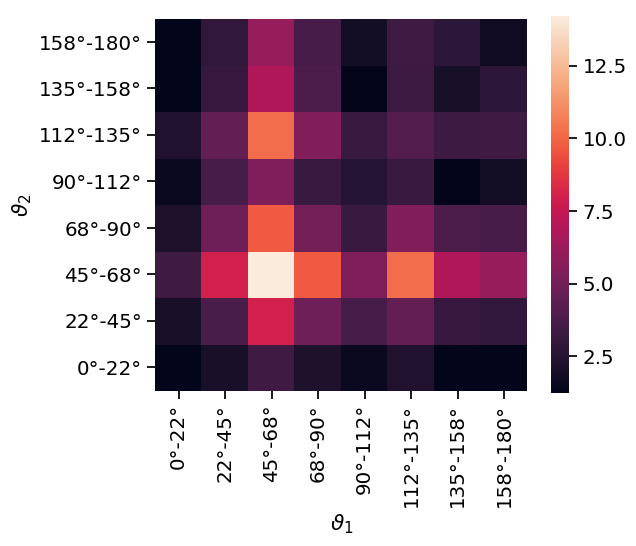

In [122]:
df2 = df[df.connection == 'non-perisomatic'].groupby(['bori_1', 'bori_2'])['n_seg_shared'].mean().reset_index()
df2 = df2.pivot('bori_1', 'bori_2', 'n_seg_shared')
g = sns.heatmap(df2, square=True)
g.figure.set_size_inches((6,5))
g.figure.set_dpi(100)
g.set_xticklabels(['{}°-{}°'.format(*a) for a in bin_labels])
g.set_yticklabels(['{}°-{}°'.format(*a) for a in bin_labels])
g.invert_yaxis()
g.set_xlabel(r'$\vartheta_1$')
g.set_ylabel(r'$\vartheta_2$')
df2

# Receptive fields

Get significant receptive fields

In [145]:
attrs = ['segment_a', 'segment_b', 'connection', 'n_seg_shared']
good_rf = 'mscore > 1.25'

cbin_edges = np.linspace(-.7, .7, 6)
cbin_centers = np.hstack((np.nan, np.round((cbin_edges[1:] + cbin_edges[:-1])/2, decimals=2), np.nan))
cbin_labels = ['[{:.1f},{:.1f}]'.format(*a) for a in zip(cbin_edges[:-1], cbin_edges[1:])]

In [146]:
rf_scores = dj.U('segment_id').aggr(nda.RFScore(), mscore='max(score)') & good_rf

In [147]:
# shi = (dj.U(*attrs) & PostSynapticPairAxonalInput.proj(n_seg_shared='n_seg_shared/n_seg_union', connection='"non-perisomatic"', 
#                                                        segment_a = 'segment_id')) + \
#       (dj.U(*attrs) & PostSynapticPairAxonalInput.proj(n_seg_shared='n_seg_shared/n_seg_union', connection='"non-perisomatic"', 
#                                                        segment_a='segment_b', segment_b='segment_id'))# + \
# crel = shi * RFCorrelation.Pair().proj('rf_corr_coef', segment_a='segment_id', segment_b='other_seg') * \
#     pref_rel.proj(ori_1='von_pref',dummy='scan_idx', segment_a='segment_id') * pref_rel.proj(segment_b='segment_id', ori_2='von_pref') * \
#     rf_scores.proj(score_a='mscore', segment_a='segment_id') * rf_scores.proj(score_b='mscore', segment_b='segment_id')

Get all *tuned* neurons with *well scoring RFs* and get their pairwise shared input. 

In [148]:
shi = (dj.U(*attrs) & SharedInput.proj('n_seg_shared', connection='shared_input_type', segment_a = 'segment_id')) + \
      (dj.U(*attrs) & SharedInput.proj('n_seg_shared', connection='shared_input_type', segment_a='segment_b', segment_b='segment_id'))# + \
#       (dj.U(*attrs) & SharedContactPair.proj('segment_a', 'segment_b', n_seg_shared='n_axon_shared', connection='"contact"')) + \
#       (dj.U(*attrs) & SharedContactPair.proj(segment_b='segment_a', segment_a='segment_b', n_seg_shared='n_axon_shared', connection='"contact"')) 

crel = shi * RFCorrelation.Pair().proj('rf_corr_coef', segment_a='segment_id', segment_b='other_seg') * \
    pref_rel.proj(ori_1='von_pref',dummy='scan_idx', segment_a='segment_id') * pref_rel.proj(segment_b='segment_id', ori_2='von_pref') * \
    rf_scores.proj(segment_a='segment_id') * rf_scores.proj(segment_b='segment_id')

In [149]:
cdf = pd.DataFrame(crel.fetch())

In [150]:
cdf['bcorr'] = cbin_centers[(np.digitize(cdf['rf_corr_coef'], cbin_edges))]
cdf['n_seg_shared'] = np.array(cdf['n_seg_shared']).astype(float)
cdf['bcorr'] = np.array(cdf['bcorr']).astype(float)



In [151]:
cdf['dori'] = np.abs(circ.cdiff(2 * cdf['ori_1'], 2 * cdf['ori_2'])/2) 
cdf['bdori'] = bin_centers[(np.digitize(np.abs(circ.cdiff(2 * cdf['ori_1'], 2 * cdf['ori_2'])/2), bin_edges))]


/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


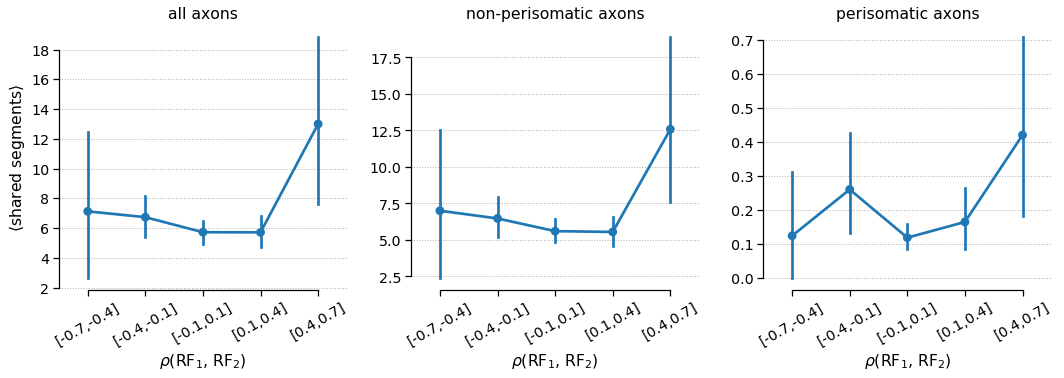

In [152]:
g = sns.catplot('bcorr', 'n_seg_shared', data=cdf, col='connection', kind='point', legend_out=True, sharey=False)
g.set_axis_labels(x_var=r'$\rho$(RF$_1$, RF$_2$)', y_var=r'$\langle$shared segments$\rangle$')

for ax in g.axes.ravel():
    ax.yaxis.grid(True, linestyle=':')
    ax.set_xticklabels(cbin_labels, rotation=30)
sns.despine(trim=True)
g.set_titles('{col_name} axons')

g.fig.savefig('figures/average_shared_input_vs_correlation.png', dpi=200)
g.fig.savefig('figures/average_shared_input_vs_correlation.pdf')

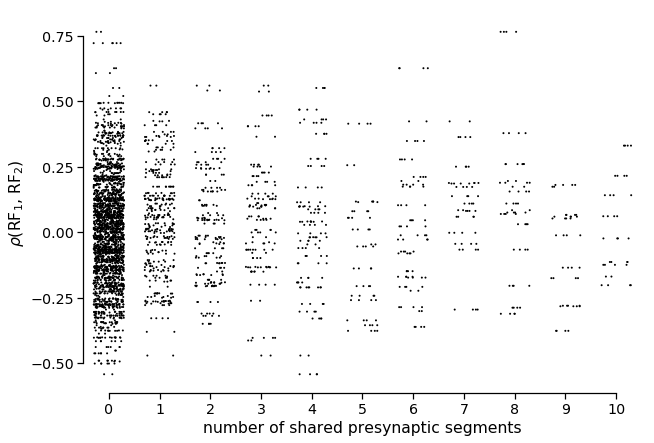

In [154]:
g = sns.stripplot( 'n_seg_shared', 'rf_corr_coef', data=cdf[cdf.n_seg_shared < 11], jitter=0.3, s=2, color='k')
g.set_xlabel(r'number of shared presynaptic segments')
g.set_xticklabels([int(e) for e in g.get_xticks()])
g.set_ylabel(r'$\rho$(RF$_1$, RF$_2$)')
sns.despine(trim=True)
g.figure.set_size_inches((10,7))
g.figure.savefig('figures/shared_input_stripplot.png', dpi=200)
g.figure.savefig('figures/shared_input_stripplot.pdf')

In [323]:
neg90 = cdf[(cdf.dori > 70/180*np.pi) & (cdf.rf_corr_coef > .40)]
neg90

,segment_a,segment_b,connection,n_seg_shared,segmentation,dummy,scan_idx,rf_corr_coef,ori_1,ori_2,bcorr,dori,bdori
780,81578447,110137680,all,0.0,1,2,3,0.493886,3.27333,1.63936,0.56,1.507623,101.25
781,81578447,110137680,non-perisomatic,0.0,1,2,3,0.493886,3.27333,1.63936,0.56,1.507623,101.25
782,81578447,110137680,perisomatic,0.0,1,2,3,0.493886,3.27333,1.63936,0.56,1.507623,101.25
1359,53349510,107860456,all,1.0,1,3,3,0.458215,1.56219,3.16470,0.56,1.539083,101.25
1360,53349510,107860456,non-perisomatic,1.0,1,3,3,0.458215,1.56219,3.16470,0.56,1.539083,101.25
1361,53349510,107860456,perisomatic,0.0,1,3,3,0.458215,1.56219,3.16470,0.56,1.539083,101.25
1392,53349510,99210911,all,0.0,1,3,3,0.492442,1.56219,6.18547,0.56,1.481687,101.25
1393,53349510,99210911,non-perisomatic,0.0,1,3,3,0.492442,1.56219,6.18547,0.56,1.481687,101.25
1394,53349510,99210911,perisomatic,0.0,1,3,3,0.492442,1.56219,6.18547,0.56,1.481687,101.25
1440,53349510,48234238,all,3.0,1,3,4,0.445472,1.56219,6.13613,0.56,1.432347,101.25


In [324]:
neg90 = [rf.mean(axis=0) for rf in (nda.RF() & 'segment_id in (53349510, 39500491)').fetch('rf')]
neg0 = [rf.mean(axis=0) for rf in (nda.RF() & 'segment_id in (107860456, 39500491)').fetch('rf')]
pos0 = [rf.mean(axis=0) for rf in (nda.RF() & 'segment_id in (83286327, 5386310)').fetch('rf')]
pos90 = [rf.mean(axis=0) for rf in (nda.RF() & 'segment_id in (53349510, 99210911)').fetch('rf')]

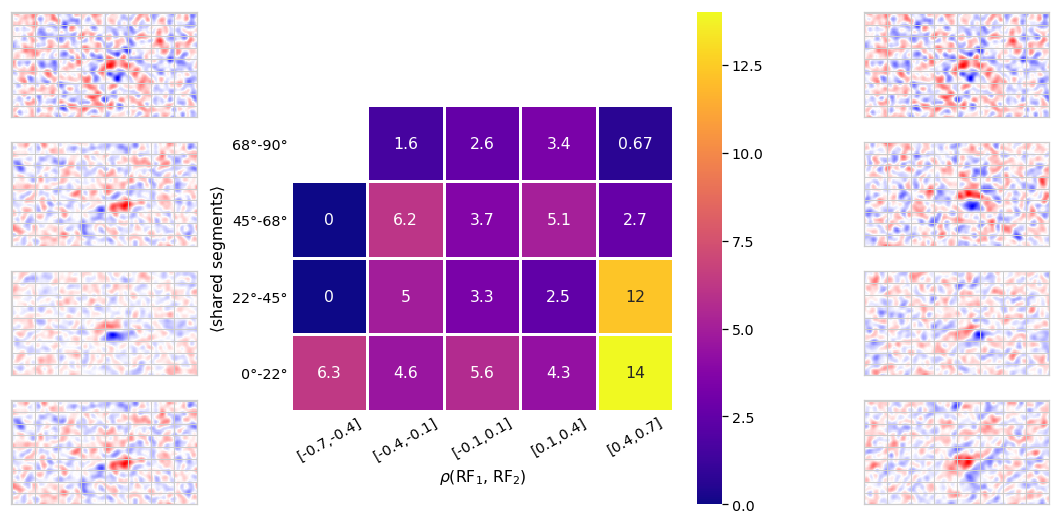

In [325]:
from itertools import chain
gs = plt.GridSpec(4, 4)
fig = plt.figure(figsize=(15,7.5))
ax_heat = fig.add_subplot(gs[:,1:3])
with sns.axes_style('whitegrid'):
    ax_tl = [fig.add_subplot(gs[0,0]), fig.add_subplot(gs[1,0])]
    ax_tr = [fig.add_subplot(gs[0,-1]), fig.add_subplot(gs[1,-1])]
    ax_br = [fig.add_subplot(gs[-2,-1]), fig.add_subplot(gs[-1,-1])]
    ax_bl = [fig.add_subplot(gs[-2,0]), fig.add_subplot(gs[-1,0])]

for tl, rf in chain(zip(ax_tl, neg90), zip(ax_bl, neg0), zip(ax_br, pos0),  zip(ax_tr, pos90)):
    rf -= rf.mean()
    v = np.abs(rf).max()
#     tl.contour(rf, cmap='bwr', levels=np.linspace(-v,v,7))
    tl.matshow(rf, cmap='bwr', vmin=-v, vmax=v)
    tl.set_xticklabels([])
    tl.set_yticklabels([])
    tl.tick_params(axis='both', length=0, width=0)

    
    
df2  = cdf
df2 = df2.groupby(['bdori', 'bcorr'])['n_seg_shared'].mean().reset_index()

df2 = df2.pivot('bdori', 'bcorr', 'n_seg_shared')
g = sns.heatmap(df2, square=True, cmap='plasma', annot=True, linewidths=2, ax=ax_heat)
g.set_yticklabels(['{}°-{}°'.format(*a) for a in bin_labels], rotation=0)
g.set_xticklabels(cbin_labels, rotation=30)
g.invert_yaxis()
g.tick_params(length=0)
g.set_xlabel(r'$\rho$(RF$_1$, RF$_2$)')
g.set_ylabel(r'$\langle$shared segments$\rangle$')

fig.subplots_adjust(wspace=.01, hspace=.01)
fig.tight_layout()
g.figure.savefig('figures/corr_vs_shared_input_heatmap.png', dpi=200)
g.figure.savefig('figures/corr_vs_shared_input_heatmap.pdf')


/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


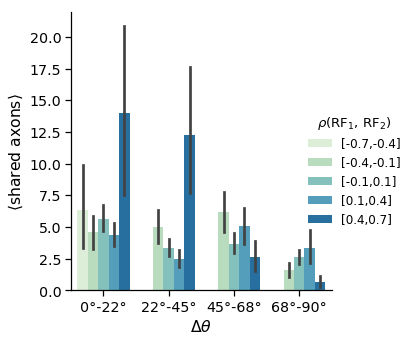

In [213]:
g = sns.catplot('bdori', 'n_seg_shared', hue='bcorr', kind='bar', palette=sns.color_palette('GnBu', n_colors=5), data=cdf, legend=False)
g.add_legend(prop={'size':12})
g.set_axis_labels(x_var=r'$\Delta \theta$', y_var=r'$\langle$shared axons$\rangle$')
g.set_xticklabels(['{}°-{}°'.format(*a) for a in bin_labels], rotation=0)
new_labels = cbin_labels
g._legend.set_title(r'$\rho$(RF$_1$, RF$_2$)')
for t, l in zip(g._legend.texts, new_labels): 
    t.set_text(l)

sns.despine()
g.fig.savefig('figures/corr_vs_shared_input_bar.png', dpi=200)
g.fig.savefig('figures/corr_vs_shared_input_bar.pdf')